# Task-4 - Decomposition

### by Musfar Muhamed Kozhikkal

A common challenge in the design and implementation of quantum circuits is that they become too extensive and complex due to the large number of qubits required. 

The number of quantum operations and the interdependence between qubits can further complicate the problem, making some traditional optimization methods ineffective or insufficient for reducing the complexity. Additionally, as the number of qubits increases, the fidelity of the circuit may be affected, which implies a greater need for advanced techniques to maintain the precision of operations.

On the other hand, some quantum computing frameworks offer predefined optimization methods that may seem like a convenient option. However, they are not always the best alternative if one has a deep understanding of the quantum hardware structure. Customizing the circuits by taking advantage of the specific features of the quantum device in use can result in a more efficient design, better adapted to the physical limitations of the system. Therefore, having a solid understanding of the hardware can make the difference between a generic quantum circuit and one that is highly optimized for performance.

## Challenge:
Consider the following code as input

In [1]:
import numpy as np
size = 5
state_values = [22,17,27,12]
state_vector = [0]*2**size
for s in state_values:
    print(np.binary_repr(s,size))
    state_vector[s] = 0.5
np.asarray(state_vector)

10110
10001
11011
01100


array([0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.5,
       0. , 0. , 0. , 0. , 0.5, 0. , 0. , 0. , 0. , 0.5, 0. , 0. , 0. ,
       0. , 0.5, 0. , 0. , 0. , 0. ])

Find a quantum circuit that represents the state vector with a depth less than 50, using the basis_gates=[x,h,rz,cx] and the given architecture


#### Importing necessary libraries

In [2]:
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit.primitives import StatevectorSampler
from qiskit.visualization import plot_histogram, plot_circuit_layout
from qiskit.transpiler.preset_passmanagers.plugin import list_stage_plugins
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime.fake_provider import FakeYorktownV2
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler

#### In the previous notebook of Task-4, we got circuit depth of 88. I tried to reduce more, for that I designed a new circuit from scratch. 

#### The initial circuit setup uses a `ccx` gate, which is not part of our basic gates set. We'll later replace this gate using Qiskit optimization to achieve our goal. The initial circuit is as below

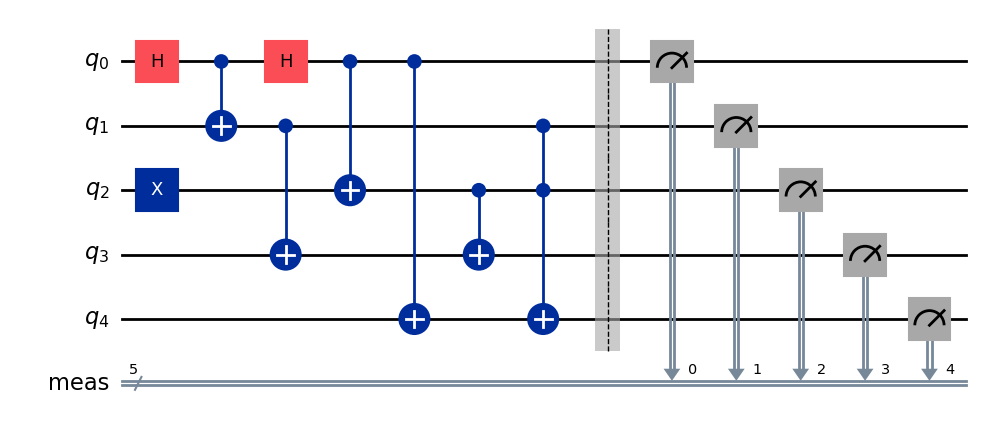

In [3]:
qc = QuantumCircuit(5)
  
qc.h(0)
qc.cx(0,1)
qc.h(0)
qc.x(2)
qc.cx(0,2)
qc.cx(0,4)
qc.cx(1,3)
qc.cx(2,3)
qc.ccx(1,2,4)

qc.measure_all()

qc.draw('mpl', idle_wires=False, fold=20)

#### Verification of Initial Circuit: Run the circuit and check whether it gives the correct states

simulated state : {'01100': 249, '11011': 255, '10001': 242, '10110': 278}
desired state : ['10110', '01100', '10001', '11011']
Does the simulatd states match our desired states  [True, True, True, True]
Circuit Depth : 7


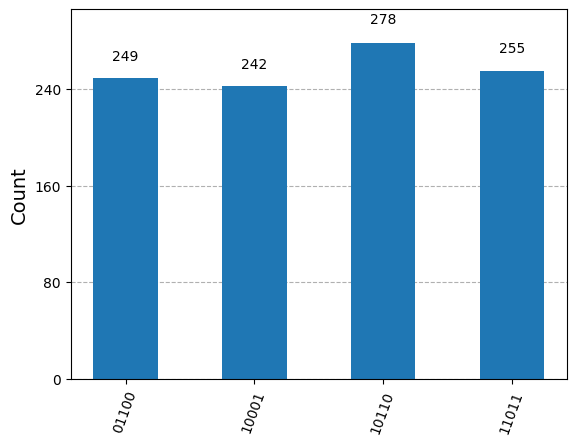

In [4]:
sampler = StatevectorSampler()

job = sampler.run([qc])

result = job.result()
counts = result[0].data.meas.get_counts()

print("simulated state :",counts)
desired_states = ['10110', '01100', '10001', '11011']
print("desired state :",desired_states)

print("Does the simulatd states match our desired states ",[ i in list(counts.keys()) for i in desired_states])

print("Circuit Depth :",qc.depth())

plot_histogram(counts)

#### The initial circuit successfully matches the desired states with a circuit depth of `7`. However, it uses a `ccx` gate, so we must replace it with basic gates to meet the requirements.

#### Not only we use the basic gates, but also we use various layout and routing optimization tools provided by Qiskit to reduce the circuit depth with only basic gates as much as possible. 

In [5]:
print("Layout optimzations :", list_stage_plugins("layout"))
print("Routing optimzations :", list_stage_plugins("routing"))

Layout optimzations : ['default', 'dense', 'sabre', 'trivial']
Routing optimzations : ['basic', 'lookahead', 'none', 'sabre', 'stochastic']


#### Try all the optimization to see the circuit depth for each. The architecture given in the challange is same as `FakeYorktownV2` 

In [6]:
backend = FakeYorktownV2()
seed=10000
basis_gates = ['x', 'h', 'rz', 'cx']

routing_options = ['basic','sabre', 'stochastic']
layout_options = ['default', 'dense', 'sabre', 'trivial']

for i in range(4):
    transpile_circuit = transpile(qc, backend, basis_gates=basis_gates, optimization_level=i, seed_transpiler=seed)
    print(f"Circuit Depth for optimization level {i} is : {transpile_circuit.depth()}")

for i in routing_options:
    transpile_circuit = transpile(qc, backend, basis_gates=basis_gates, optimization_level=3, routing_method=i, seed_transpiler=seed)
    print(f"Circuit Depth for {i} routing is : {transpile_circuit.depth()}")

for i in layout_options:
    transpile_circuit = transpile(qc, backend, basis_gates=basis_gates, optimization_level=3, layout_method=i, seed_transpiler=seed)
    print(f"Circuit Depth for {i} layout is : {transpile_circuit.depth()}")


Circuit Depth for optimization level 0 is : 25
Circuit Depth for optimization level 1 is : 28
Circuit Depth for optimization level 2 is : 24
Circuit Depth for optimization level 3 is : 24
Circuit Depth for basic routing is : 55
Circuit Depth for sabre routing is : 24
Circuit Depth for stochastic routing is : 78
Circuit Depth for default layout is : 24
Circuit Depth for dense layout is : 32
Circuit Depth for sabre layout is : 24
Circuit Depth for trivial layout is : 32


#### The lowest depth achieved is `24` using optimization level 2 or 3 with `sabre` layout and routing. 

#### Taking the best optimized circuit and drawing it

Optimizal Circuit Depth is : 24


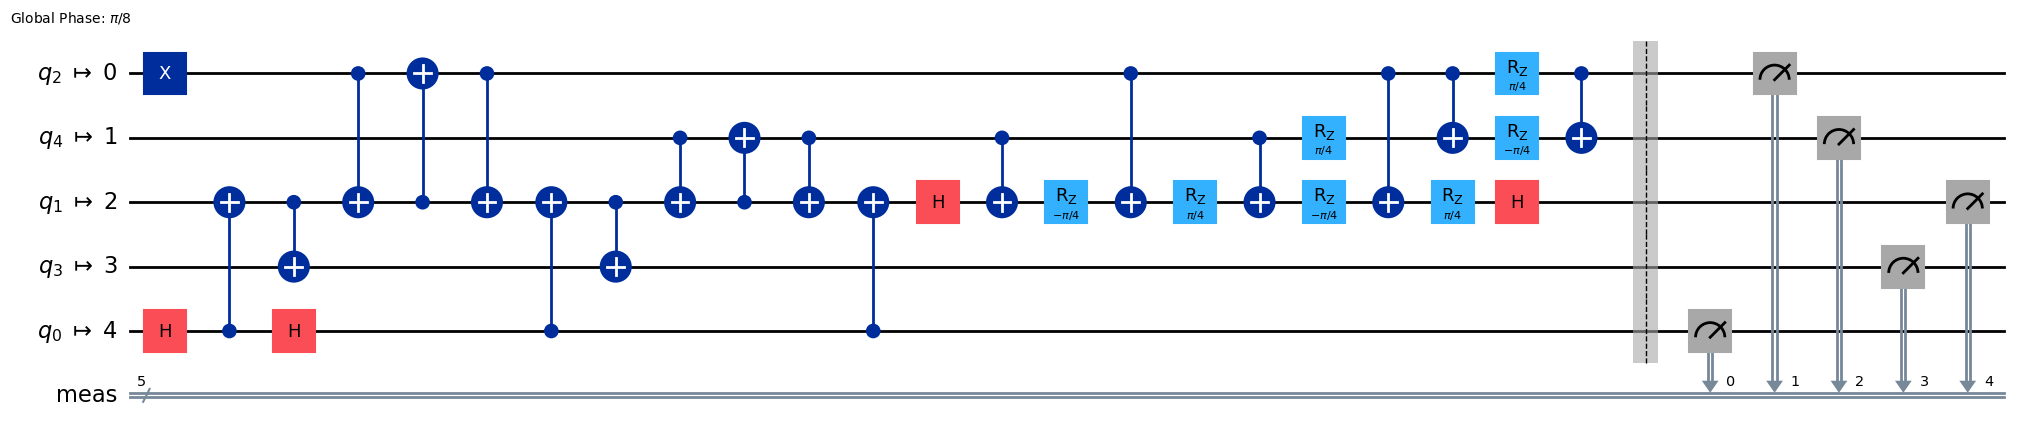

In [7]:
transpile_circuit = transpile(qc, backend, basis_gates=basis_gates, optimization_level=3, routing_method='sabre', layout_method='sabre', seed_transpiler=seed)
print(f"Optimizal Circuit Depth is : {transpile_circuit.depth()}")
transpile_circuit.draw('mpl', idle_wires=False, fold=40)

#### Ploting the qubits on the architecture

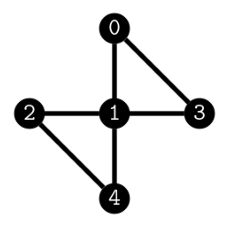

In [8]:
plot_circuit_layout(transpile_circuit, backend)

#### Here we can see that we have achieved the desired states with a reduced circuit depth of `24`, meeting the depth requirement of under `50`

#### Verification of Optimized Circuit: The verfication to check to see whether we can get the descried solution from this optimized circuit

simulated state : {'11011': 262, '01100': 240, '10001': 266, '10110': 256}
desired state : ['10110', '01100', '10001', '11011']
Does the simulatd states match our desired states  [True, True, True, True]
Circuit Depth : 24


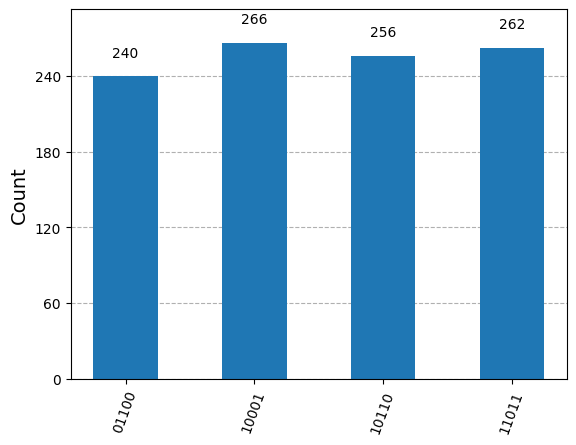

In [9]:
sampler = StatevectorSampler()
job_transpile = sampler.run([transpile_circuit])

result_transpile = job_transpile.result()
counts_transpile = result_transpile[0].data.meas.get_counts()

print("simulated state :",counts_transpile)
print("desired state :",desired_states)
print("Does the simulatd states match our desired states ",[ i in list(counts_transpile.keys()) for i in desired_states])
print("Circuit Depth :",transpile_circuit.depth())
plot_histogram(counts_transpile)

## We have completed the task with a circuit depth of 24

-----

# Additional section: Running the circuit on IBM’s real quantum hardware introduces noise, so results may vary slightly.

#### IBM token API is need below, which I removed due to privacy. (Use your own API while you are verifing this section)

In [10]:
QiskitRuntimeService.save_account(
    channel="ibm_quantum",
    token="IBM_TOKEN_API",
    set_as_default=True,
    overwrite=True,
)

service = QiskitRuntimeService()

#### To run on hardware, select the backend with the fewest number of jobs in the queue


In [11]:
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(operational=True, simulator=False, min_num_qubits=127)
backend.name

'ibm_brisbane'

#### Run on the hardware quantum computer and print the job ID

In [12]:
target = backend.target

sampler = Sampler(backend)

IBM_circuit = transpile(qc, target=target, basis_gates=basis_gates, optimization_level=3, routing_method='sabre', layout_method='sabre', seed_transpiler=seed)

job_IBM = sampler.run([IBM_circuit])
print(job_IBM.job_id())

cwsc9k62ac5g008j159g


#### You can use the `job_id` to get back the result of the computation from the IBM and Hence you can see the result with having to run of the quantum computer again.  

In [13]:
# skip this cell if you are running on the hardware again.
job_id = "cwsc9k62ac5g008j159g"
job_IBM = service.job(job_id)

#### See the circuit 

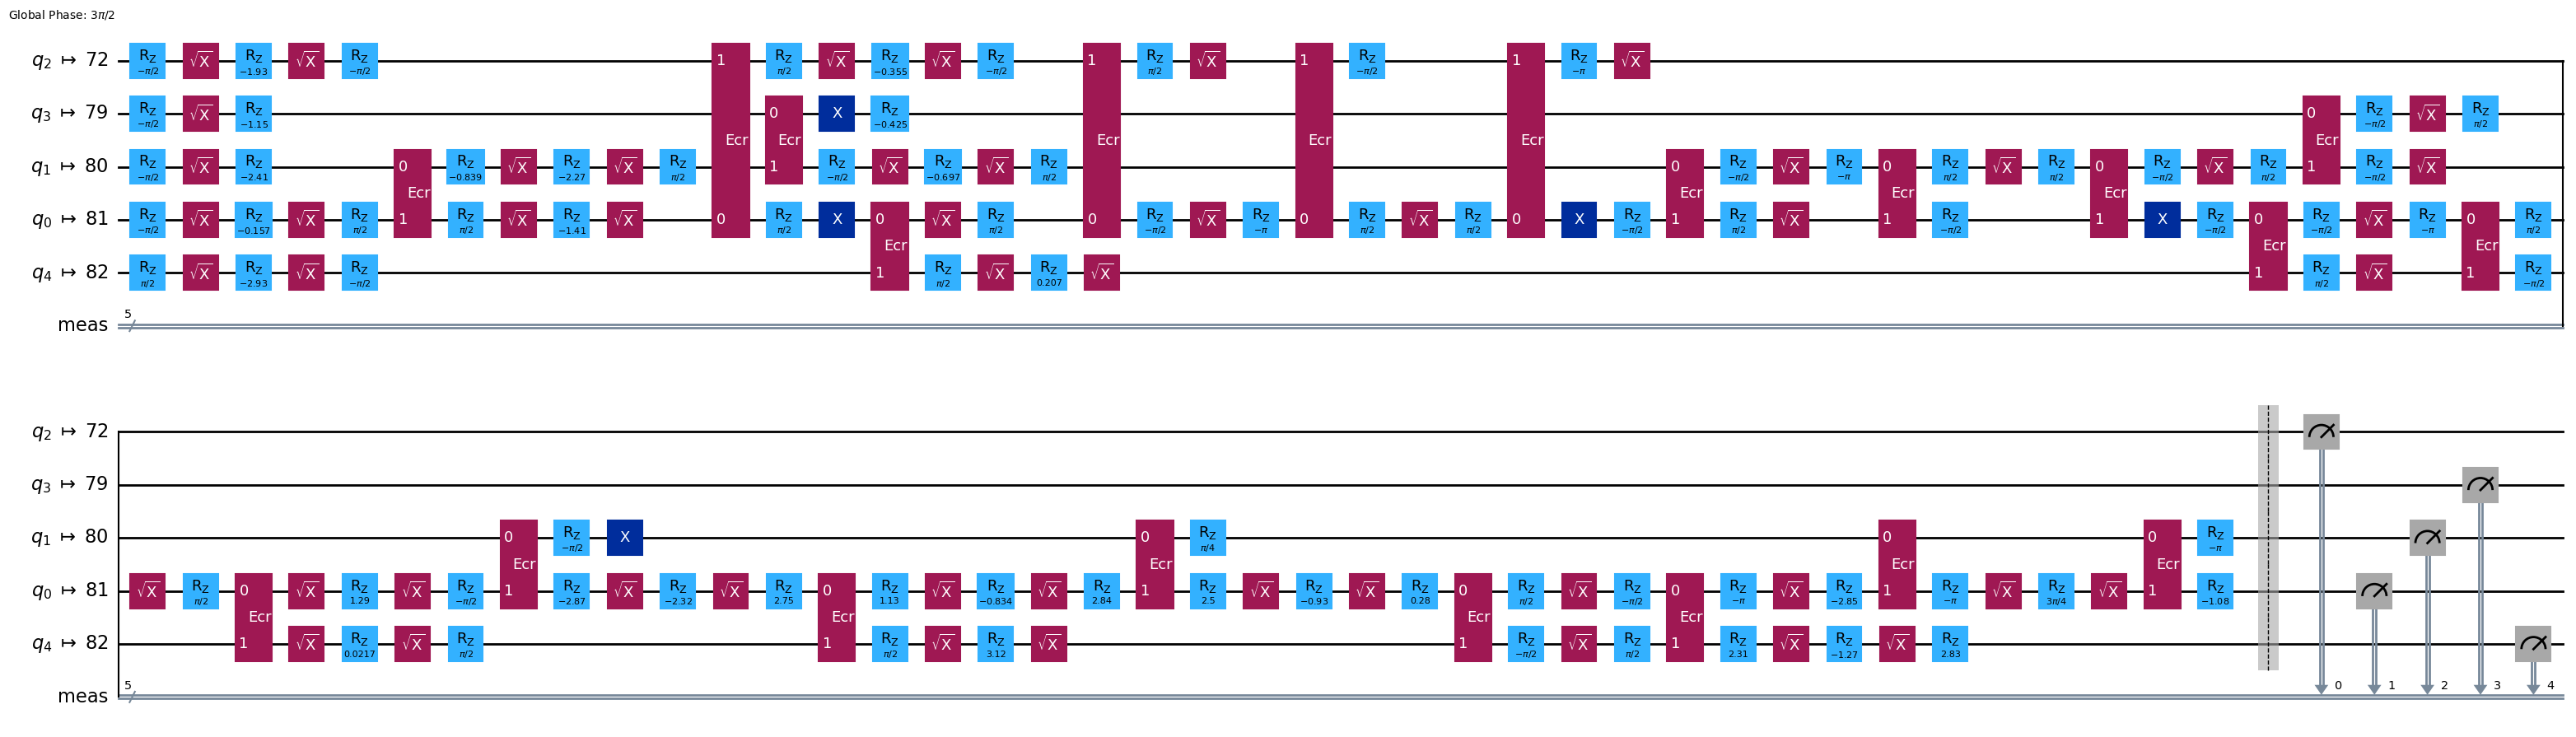

In [14]:
IBM_circuit.draw(output="mpl", idle_wires=False, style="iqp",fold=46)

#### Verfication to check to see whether we can get the descried solution from this optimized circuit

simulated state : {'10000': 362, '11111': 305, '11000': 167, '00001': 129, '10111': 82, '00111': 47, '11100': 131, '10010': 185, '00110': 57, '00101': 307, '11110': 159, '11010': 436, '10101': 56, '11011': 137, '01010': 105, '00011': 65, '01001': 86, '10001': 99, '10011': 66, '00000': 141, '01011': 93, '10100': 101, '01101': 117, '00100': 152, '00010': 65, '01000': 78, '01111': 72, '11001': 38, '01110': 72, '11101': 49, '10110': 80, '01100': 57}
desired state : ['10110', '01100', '10001', '11011']
Does the simulatd states match our desired states  [True, True, True, True]
Circuit Depth : 85


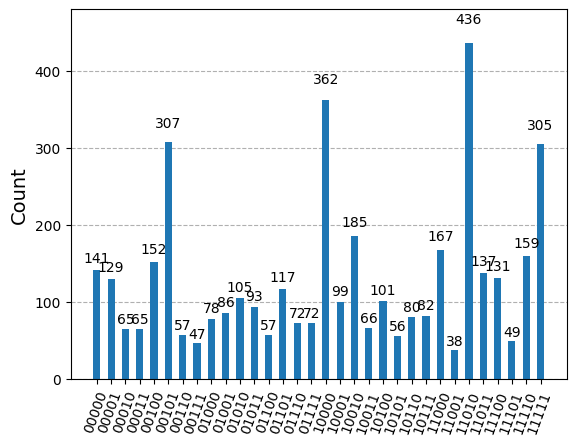

In [15]:
result_IBM = job_IBM.result()

counts_IBM = result_IBM[0].data.meas.get_counts()

print("simulated state :",counts_IBM)
print("desired state :",desired_states)
print("Does the simulatd states match our desired states ",[ i in list(counts_IBM.keys()) for i in desired_states])
print("Circuit Depth :",IBM_circuit.depth())

plot_histogram(counts_IBM)

#### Results Comparison

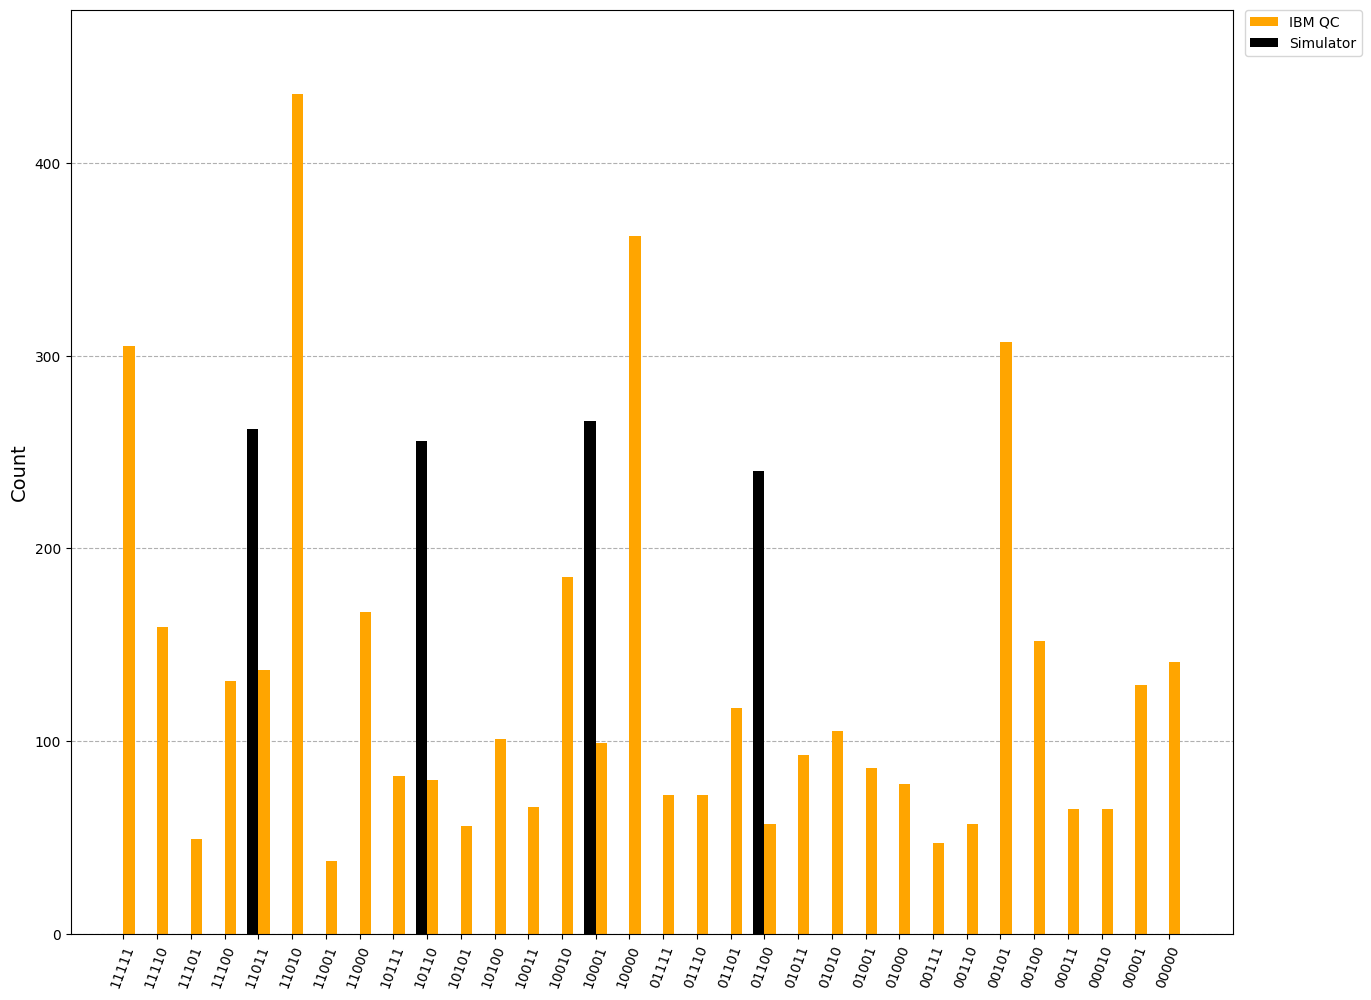

In [16]:
plot_histogram(
    [counts_IBM, counts_transpile],
    legend=["IBM QC", "Simulator"],
    sort="desc",
    figsize=(15, 12),
    color=["orange", "black"],
    bar_labels=False,
)

| Platform             | Circuit Depth | Matched States |
|----------------------|---------------|----------------|
| Optimized Simulator  | 24            | Yes            |
| IBM Quantum Hardware | 85            | Yes (with noise) |

### The optimized circuit meets the depth requirement on the simulator, achieving all desired states with a depth of `24`. On IBM Quantum hardware, the increased depth and noise impact the results but still produce the desired states.
